In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score,recall_score,f1_score
import math
from matplotlib.colors import LogNorm

# Analysis 

In [12]:
# read in each set of business trajectories network's recommendations based on max_direct_neighbors
# max_direct_neighbors: recommendations dataframe
recommendations_dict = {i+1: pd.read_csv(f'stash/network_recommendations_with_rf_predictions/network_recommendations_with_rf_predictions_{i+1}_max_direct_neighbors.csv',index_col=[0])
                        for i in range(20)}

In [60]:
# match distributions

def num_matches_per_list_distribution(recommendations,max_direct_neighbors):
    # given network recommendations with constraint max_direct_neighbors, generates distribution of 
    # number of matches per list 
    
    num_matches_per_user = recommendations[['user','true_like']].groupby('user').agg(sum)
    num_matches_frequencies = num_matches_per_user['true_like'].value_counts().sort_index()
    num_matches_frequencies = num_matches_frequencies/num_matches_frequencies.sum()
    
    num_matches_frequencies.plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel('number of matches in list')
    plt.ylabel('probability')
    plt.title(f'Distribution of matches per list: {max_direct_neighbors} max direct neighbors')
    plt.close()
    return num_matches_frequencies
    

def num_matches_at_position_distribution(recommendations,max_direct_neighbors):
    # given network recommendations with constraint max_direct_neighbors, generates distribution of 
    # number of matches at position in list distribution (positions in list are 1, ..., 20)
    
    matches_at_position = defaultdict(int)  
    for user, user_recommendations in recommendations.groupby('user'):
        for item, row in user_recommendations.iterrows():
            position_in_list = row['network_rank']
            is_true_match = row['true_like']
            if is_true_match == 1: # because network prediction is 1 for each recommendation
                matches_at_position[position_in_list] += 1
    num_matches_at_position_df = pd.DataFrame.from_dict(dict(matches_at_position), orient='index').sort_index()
    num_matches_at_position = num_matches_at_position_df[0]
    num_matches_at_position = num_matches_at_position/num_matches_at_position.sum()
    
    num_matches_at_position.plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel('position in list')
    plt.ylabel('probability of match at position')
    plt.title(f'Distribution of matches at position in list: {max_direct_neighbors} max direct neighbors')
    plt.close()
    return num_matches_at_position

In [2]:
# compute num_matches_per_list and num_matches_at_position for each set of network recommendations
num_matches_per_list = dict()
num_matches_at_position = dict()

for i in range(20):
    print(i+1)
    max_direct_neighbors = i+1
    recommendations = recommendations_dict[i+1]
    num_matches_per_list[max_direct_neighbors] = num_matches_per_list_distribution(recommendations,max_direct_neighbors)
    num_matches_at_position[max_direct_neighbors] = num_matches_at_position_distribution(recommendations,max_direct_neighbors)
    
num_matches_per_list_df = pd.DataFrame.from_dict(num_matches_per_list,orient='index',columns=[i for i in range(21)])
num_matches_per_list_df.fillna(0,inplace=True)

num_matches_at_position_df = pd.DataFrame.from_dict(num_matches_at_position,orient='index',columns=[i+1 for i in range(20)])
num_matches_at_position_df.fillna(0,inplace=True)

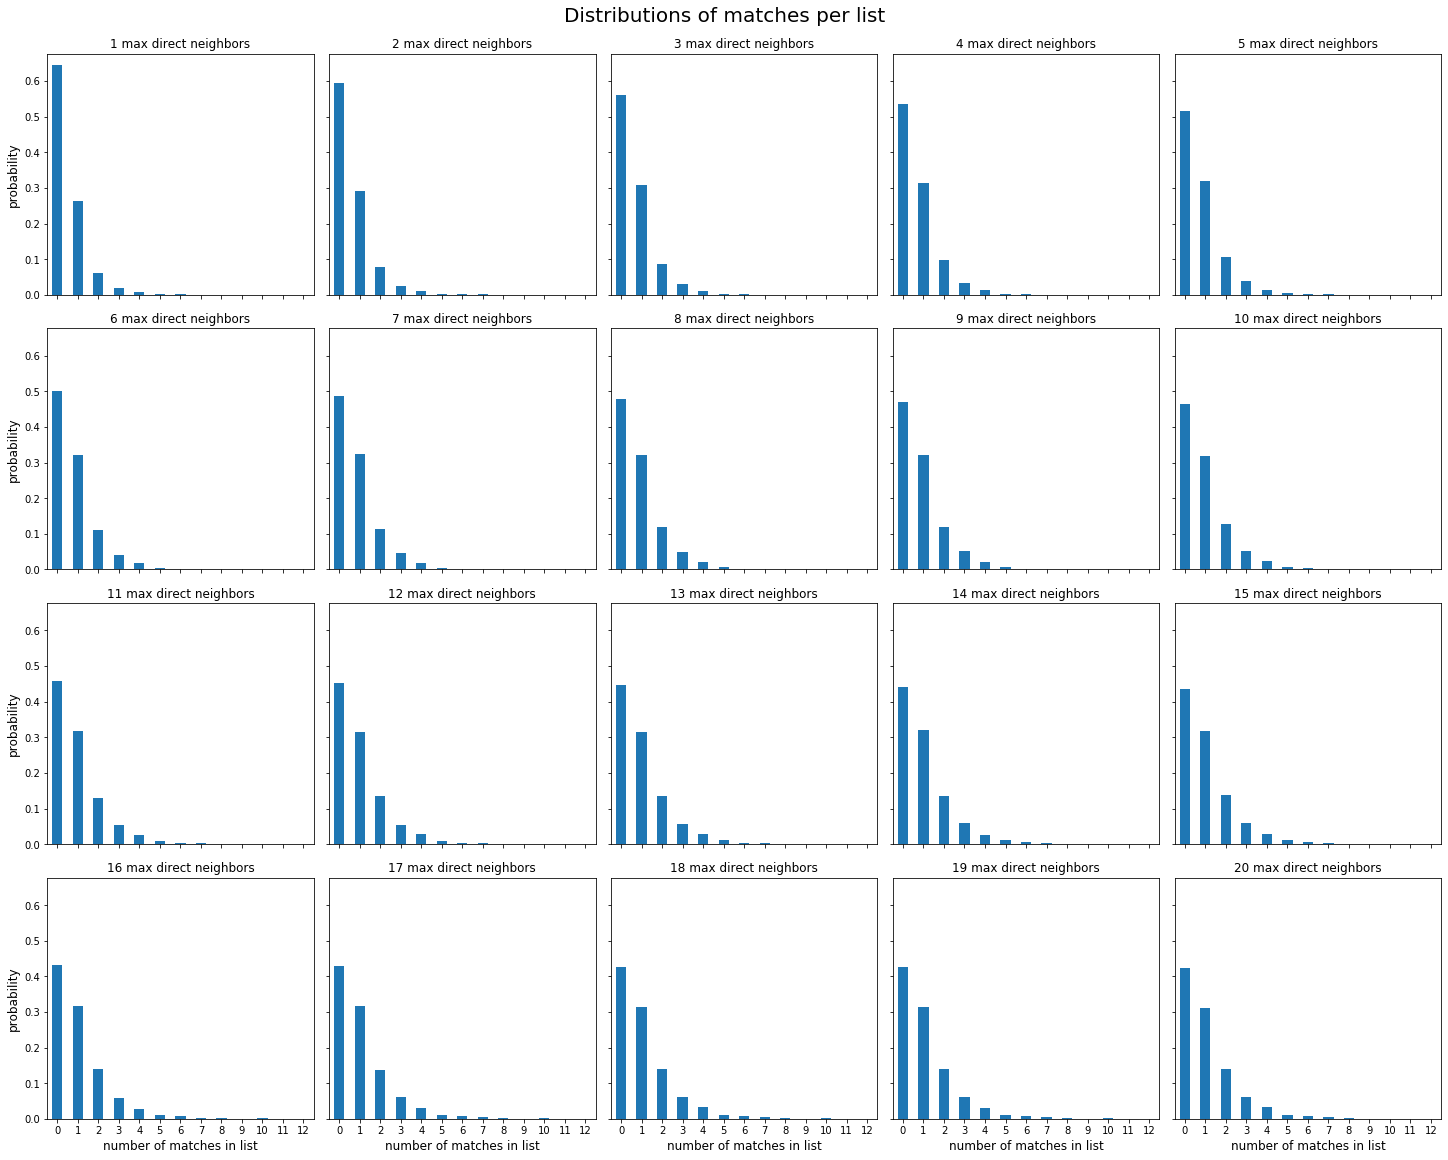

In [17]:
fig,axs = plt.subplots(4,5,figsize=(20,16),constrained_layout=True,sharex=True, sharey=True)
fig.suptitle('Distributions of matches per list',fontsize=20)
count = 1

for row in axs:
    for ax in row:
        ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
        num_matches_per_list[count].plot(kind='bar',ax=ax)
        ax.tick_params(labelrotation=0)
        ax.get_legend().remove()
        ax.set_title(f'{count} max direct neighbors')
        if count in [16,17,18,19,20]:
            ax.set_xlabel('number of matches in list',fontsize=12)
        if count in [1,6,11,16]:
            ax.set_ylabel('probability',fontsize=12)
        if count not in [16,17,18,19,20]:
            ax.set_xlabel('')
            
        count+=1

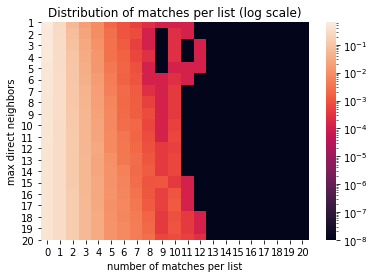

In [27]:
data = num_matches_per_list_df.replace(0,0.00000001)
log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

sn.heatmap(
    data,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
)
plt.xlabel('number of matches per list')
plt.ylabel('max direct neighbors')
plt.title('Distribution of matches per list (log scale)')

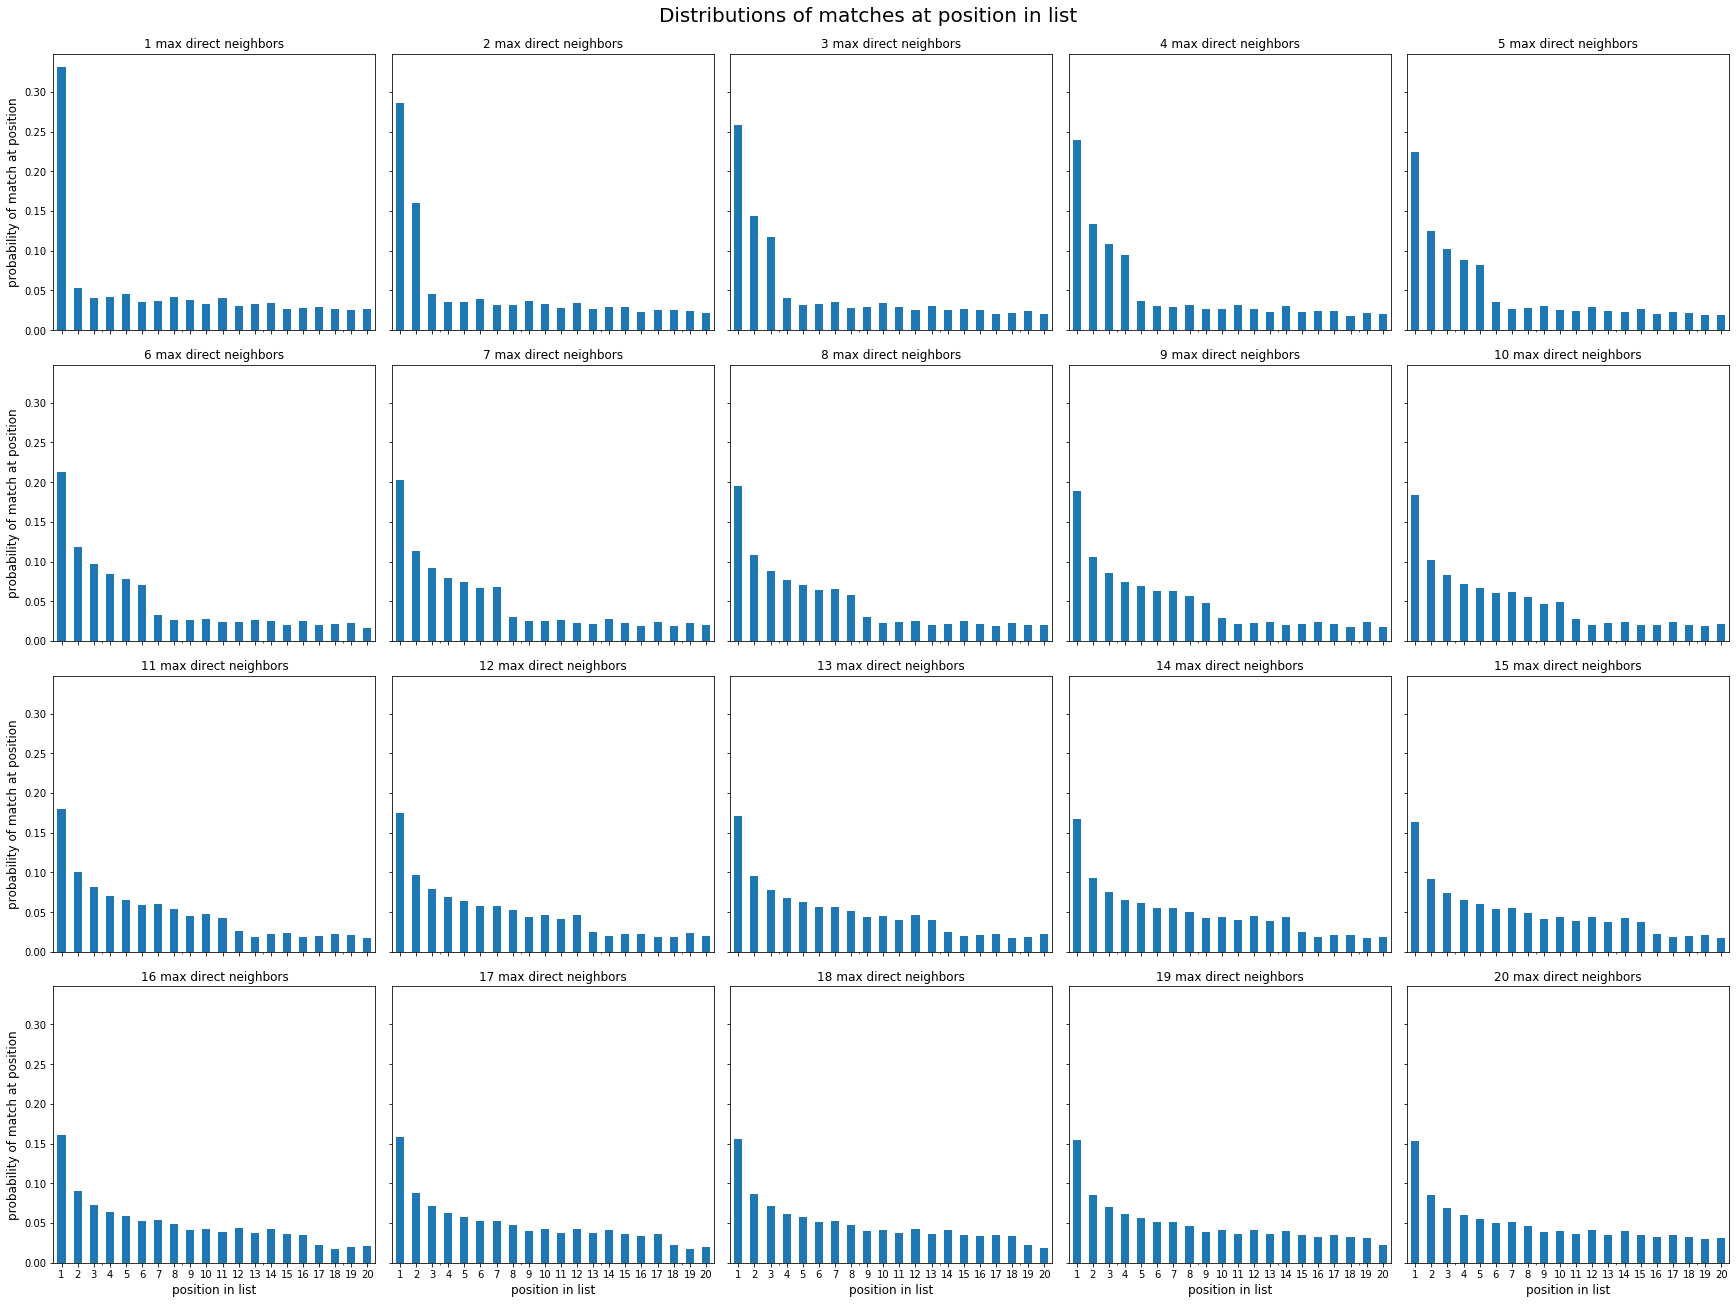

In [18]:
fig,axs = plt.subplots(4,5,figsize=(24,18),constrained_layout=True,sharex=True, sharey=True)
fig.suptitle('Distributions of matches at position in list',fontsize=20)
count = 1

for row in axs:
    for ax in row:
        num_matches_at_position[count].plot(kind='bar',ax=ax)
        ax.tick_params(labelrotation=0)
        ax.get_legend().remove()
        ax.set_title(f'{count} max direct neighbors')
        if count in [16,17,18,19,20]:
            ax.set_xlabel('position in list',fontsize=12)
        if count in [1,6,11,16]:
            ax.set_ylabel('probability of match at position',fontsize=12)
        if count not in [16,17,18,19,20]:
            ax.set_xlabel('')
            
        count+=1

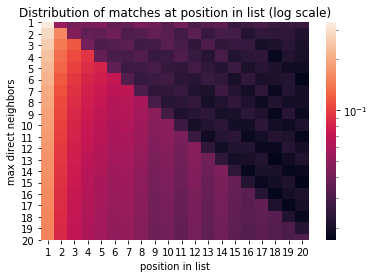

In [28]:
data = num_matches_at_position_df.replace(0,0.00000001)
log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

sn.heatmap(
    data,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
)
plt.xlabel('position in list')
plt.ylabel('max direct neighbors')
plt.title('Distribution of matches at position in list (log scale)')

In [151]:
# rank computations 

def list_rank(true_col,prediction_col,df):
    # compute rank of list of recommendations
    rank_sum = 0
    for rank, row in df.iterrows(): # using index as rank 
        if row[true_col] == 1 and row[prediction_col] == 1: 
            correct_prediction = 1
        else:
            correct_prediction = 0
        rank_sum += (2**-(rank+1))*correct_prediction
    return rank_sum

def method_rank_pmf(recommendations,
                    max_direct_neighbors,
                    method,
                    true_col,
                    method_pred_col,
                    sort_col,
                    asc = True
):
    
    ranks_of_lists = []
    for user, user_recommendations in recommendations.groupby('user'):
        user_recommendations = user_recommendations.sort_values(by=[sort_col],ascending=asc).reset_index().drop('index',axis=1)
        user_list_rank= list_rank(true_col=true_col,
                                  prediction_col=method_pred_col,
                                  df=user_recommendations)
        ranks_of_lists.append(user_list_rank)
    rank_counts = pd.Series(ranks_of_lists).value_counts().sort_index()
    rank_probabilities = rank_counts/rank_counts.sum()
    return rank_probabilities

def random_shuffle_rank_pmf(recommendations,
                            max_direct_neighbors,
                            method,
                            true_col,
                            method_pred_col
):
    ranks_of_lists = []
    for _ in range(30):
        for user, user_recommendations in recommendations.groupby('user'):
            user_recommendations = user_recommendations.sample(frac=1) # SHUFFLE ROWS
            user_list_rank= list_rank(true_col=true_col,
                                      prediction_col=method_pred_col,
                                      df=user_recommendations)
            ranks_of_lists.append(user_list_rank)
    rank_counts = pd.Series(ranks_of_lists).value_counts().sort_index()
    rank_probabilities = rank_counts/rank_counts.sum()
    return rank_probabilities

def cdf_from_pmf(pmf):
    return np.cumsum(pmf)

def ccdf_from_pmf(pmf):
    # compute complementary cumulative distribution function
    cdf = np.cumsum(pmf)
    ccdf = 1 - cdf
    return ccdf

In [198]:
# for different methods -> max_direct_neighbors: rank probability mass function
business_network_rank_pmfs = dict()
random_forest_with_lat_cat_rank_pmfs = dict()
random_forest_without_lat_cat_rank_pmfs = dict()
random_shuffle_method_rank_pmfs = dict()

# for different methods -> max_direct_neighbors: rank complementary cumulative distribution function
business_network_rank_ccdf = dict()
random_forest_with_lat_cat_rank_ccdf = dict()
random_forest_without_lat_cat_rank_ccdf = dict()
random_shuffle_method_rank_ccdf = dict()

In [1]:
for i in range(20):
    print(i+1)
    max_direct_neighbors = i+1
    recommendations = recommendations_dict[max_direct_neighbors]
    business_network_rank_pmfs[max_direct_neighbors] = method_rank_pmf(
                                                            recommendations = recommendations,
                                                            max_direct_neighbors = max_direct_neighbors,
                                                            method = 'network',
                                                            true_col= 'true_like',
                                                            method_pred_col = 'business_net_pred',
                                                            sort_col = 'network_rank'
                                                        )
    random_forest_with_lat_cat_rank_pmfs[max_direct_neighbors] = method_rank_pmf(
                                                            recommendations = recommendations,
                                                            max_direct_neighbors = max_direct_neighbors,
                                                            method = 'rf_net',
                                                            true_col= 'true_like',
                                                            method_pred_col = 'rf_net_pred',
                                                            sort_col = 'rf_net_prob_like',
                                                            asc=False
                                                        )
    random_forest_without_lat_cat_rank_pmfs[max_direct_neighbors] = method_rank_pmf(
                                                            recommendations = recommendations,
                                                            max_direct_neighbors = max_direct_neighbors,
                                                            method = 'rf_noNet',
                                                            true_col= 'true_like',
                                                            method_pred_col = 'rf_NoNet_pred',
                                                            sort_col = 'rf_NoNet_prob_like',
                                                            asc=False
                                                        )
    random_shuffle_method_rank_pmfs[max_direct_neighbors] = random_shuffle_rank_pmf(
                                                            recommendations = recommendations,
                                                            max_direct_neighbors = max_direct_neighbors,
                                                            method = 'shuffle',
                                                            true_col= 'true_like',
                                                            method_pred_col = 'business_net_pred'
                                                        )
    business_network_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(business_network_rank_pmfs[max_direct_neighbors])
    random_forest_with_lat_cat_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_forest_with_lat_cat_rank_pmfs[max_direct_neighbors])
    random_forest_without_lat_cat_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_forest_without_lat_cat_rank_pmfs[max_direct_neighbors])
    random_shuffle_method_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_shuffle_method_rank_pmfs[max_direct_neighbors])

In [252]:
business_network_rank_pmfs_adj= dict()
random_forest_with_lat_cat_rank_pmfs_adj= dict()
random_forest_without_lat_cat_rank_pmfs_adj= dict()
random_shuffle_method_rank_pmfs_adj= dict()

business_network_rank_cdf = dict()
random_forest_with_lat_cat_rank_cdf = dict()
random_forest_without_lat_cat_rank_cdf = dict()
random_shuffle_method_rank_cdf = dict()

business_network_rank_ccdf = dict()
random_forest_with_lat_cat_rank_ccdf = dict()
random_forest_without_lat_cat_rank_ccdf = dict()
random_shuffle_method_rank_ccdf = dict()

In [253]:
for i in range(20):
    bus_net_ser = business_network_rank_pmfs[i+1]
    rf_cat_ser =random_forest_with_lat_cat_rank_pmfs[i+1]
    rf_no_cat_ser =random_forest_without_lat_cat_rank_pmfs[i+1]
    shuffle_ser =random_shuffle_method_rank_pmfs[i+1] 
    
    common_index = bus_net_ser.index.union(rf_cat_ser.index).union(rf_no_cat_ser.index).union(shuffle_ser.index)
    bus_net_ser = bus_net_ser.reindex(common_index,fill_value=0)
    rf_cat_ser = rf_cat_ser.reindex(common_index,fill_value=0)
    rf_no_cat_ser = rf_no_cat_ser.reindex(common_index,fill_value=0)
    shuffle_ser = shuffle_ser.reindex(common_index,fill_value=0)
    
    business_network_rank_pmfs_adj[i+1] = bus_net_ser         
    random_forest_with_lat_cat_rank_pmfs_adj[i+1] = rf_cat_ser
    random_forest_without_lat_cat_rank_pmfs_adj[i+1] = rf_no_cat_ser 
    random_shuffle_method_rank_pmfs_adj[i+1]= shuffle_ser

In [255]:
for i in range(20):
    max_direct_neighbors = i+1
    business_network_rank_cdf[max_direct_neighbors] = cdf_from_pmf(business_network_rank_pmfs_adj[max_direct_neighbors])
    random_forest_with_lat_cat_rank_cdf[max_direct_neighbors] = cdf_from_pmf(random_forest_with_lat_cat_rank_pmfs_adj[max_direct_neighbors])
    random_forest_without_lat_cat_rank_cdf[max_direct_neighbors] = cdf_from_pmf(random_forest_without_lat_cat_rank_pmfs_adj[max_direct_neighbors])
    random_shuffle_method_rank_cdf[max_direct_neighbors] = cdf_from_pmf(random_shuffle_method_rank_pmfs_adj[max_direct_neighbors])
    
    business_network_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(business_network_rank_pmfs_adj[max_direct_neighbors])
    random_forest_with_lat_cat_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_forest_with_lat_cat_rank_pmfs_adj[max_direct_neighbors])
    random_forest_without_lat_cat_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_forest_without_lat_cat_rank_pmfs_adj[max_direct_neighbors])
    random_shuffle_method_rank_ccdf[max_direct_neighbors] = ccdf_from_pmf(random_shuffle_method_rank_pmfs_adj[max_direct_neighbors])
    
 

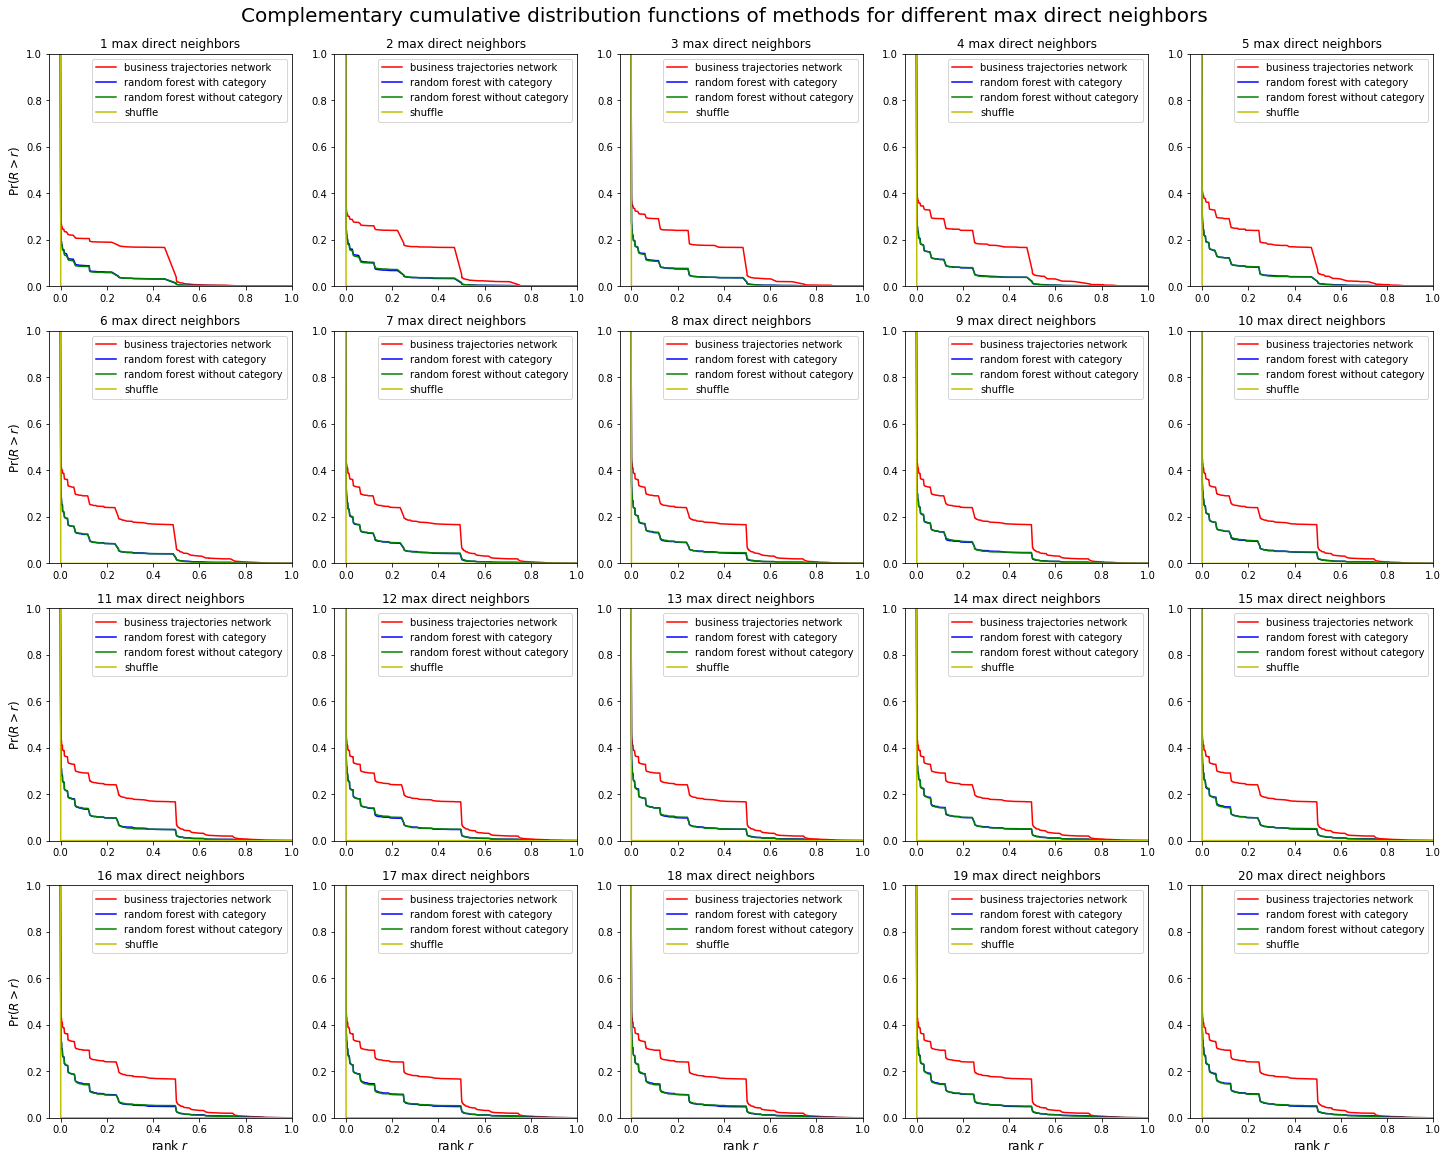

In [278]:
fig,axs = plt.subplots(4,5,figsize=(20,16),constrained_layout=True)
fig.suptitle('Complementary cumulative distribution functions of methods for different max direct neighbors',fontsize=20)

count = 1

for row in axs:
    for ax in row:
        bus_net_ser = business_network_rank_ccdf[count]
        rf_cat_ser =random_forest_with_lat_cat_rank_ccdf[count] 
        rf_no_cat_ser = random_forest_without_lat_cat_rank_ccdf[count]
        shuffle_ser = random_shuffle_method_rank_ccdf[count]
        
        adj_df = pd.DataFrame({0:[-.001],1:[1]}).set_index(0)
        
        pd.concat([adj_df,bus_net_ser]).plot(kind='line',color='r',ax=ax)
        pd.concat([adj_df,rf_cat_ser]).plot(kind='line',ax=ax,color='b')
        pd.concat([adj_df,rf_no_cat_ser]).plot(kind='line',ax=ax,color='g')
        pd.concat([adj_df,shuffle_ser]).plot(kind='line',ax=ax,color='y')
        ax.set_title(f'{count} max direct neighbors')
        ax.legend(['business trajectories network',
                   'random forest with category',
                   'random forest without category',
                   'shuffle'])
        ax.set_ylim(0, 1)
        ax.set_xlim(-.05,1)
        if count in [16,17,18,19,20]:
            ax.set_xlabel(r'rank $r$',fontsize=12)
        if count in [1,6,11,16]:
            ax.set_ylabel(r'$\Pr(R > r)$',fontsize=12)
        if count not in [16,17,18,19,20]:
            ax.set_xlabel('')
            
        count+=1
        
# plt.tight_layout()
plt.savefig('stash/figures/rank/method_ccdfs_for_each_max_direct_neighbors.png')

In [13]:
# def std_eval(recommendations,
#             true_col,
#             method_pred_col
# ):
#     precisions = []
#     recalls = []
#     f1_scores = []
#     for user, user_recommendations in recommendations.groupby('user'):
#         precisions.append(precision_score(user_recommendations[true_col],user_recommendations[method_pred_col]))
#         recalls.append(recall_score(user_recommendations[true_col],user_recommendations[method_pred_col]))
#         f1_scores.append(f1_score(user_recommendations[true_col],user_recommendations[method_pred_col]))
        
#     precision_counts = pd.Series(precisions).value_counts().sort_index()
#     precision_probabilities = precision_counts/precision_counts.sum()
    
#     recall_counts = pd.Series(recalls).value_counts().sort_index()
#     recall_probabilities = recall_counts/recall_counts.sum() 
    
#     f1_score_counts = pd.Series(f1_scores).value_counts().sort_index()
#     f1_score_probabilities = f1_score_counts/f1_score_counts.sum()   
    
    
#     return precision_probabilities,recall_probabilities,f1_score_probabilities


# business_network_rank_precisions = dict()
# random_forest_with_lat_cat_rank_precisions = dict()
# random_forest_without_lat_cat_rank_precisions = dict()

# business_network_rank_recalls = dict()
# random_forest_with_lat_cat_rank_recalls = dict()
# random_forest_without_lat_cat_rank_recalls = dict()

# business_network_rank_f1_scores = dict()
# random_forest_with_lat_cat_rank_f1_scores = dict()
# random_forest_without_lat_cat_rank_f1_scores = dict()

# for i in range(20):
#     print(i+1)
#     max_direct_neighbors = i+1
#     recommendations = recommendations_dict[max_direct_neighbors]    
#     bus_prec,bus_rec,bus_f1 = std_eval(recommendations = recommendations,
#                                         true_col= 'true_like',
#                                         method_pred_col = 'business_net_pred'
#                                     )
    
#     business_network_rank_precisions[max_direct_neighbors] = bus_prec
#     business_network_rank_recalls[max_direct_neighbors] = bus_rec
#     business_network_rank_f1_scores[max_direct_neighbors] = bus_f1
    
    
#     rf1_prec,rf1_rec,rf1_f1 = std_eval(recommendations = recommendations,
#                                         true_col= 'true_like',
#                                         method_pred_col = 'rf_net_pred'
#                                     )
    
#     random_forest_with_lat_cat_rank_precisions[max_direct_neighbors] = rf1_prec
#     random_forest_with_lat_cat_rank_recalls[max_direct_neighbors] = rf1_rec
#     random_forest_with_lat_cat_rank_f1_scores[max_direct_neighbors] = rf1_f1
    

#     rf2_prec,rf2_rec,rf2_f1 = std_eval(recommendations = recommendations,
#                                         true_col= 'true_like',
#                                         method_pred_col = 'rf_NoNet_pred'
#                                     )
    
#     random_forest_without_lat_cat_rank_precisions[max_direct_neighbors] = rf2_prec
#     random_forest_without_lat_cat_rank_recalls[max_direct_neighbors] = rf2_rec
#     random_forest_without_lat_cat_rank_f1_scores[max_direct_neighbors] = rf2_f1
    
 

In [5]:
# fig,axs = plt.subplots(4,5,figsize=(20,16),constrained_layout=True)
# fig.suptitle('Precisions of methods for different max direct neighbors',fontsize=20)

# count = 1

# for row in axs:
#     for ax in row:
#         business_network_rank_precisions[count].plot(kind='line',ax=ax,color = 'r')
#         random_forest_with_lat_cat_rank_precisions[count].plot(kind='line',ax=ax,color = 'b') 
#         random_forest_without_lat_cat_rank_precisions[count].plot(kind='line',ax=ax,color = 'g')

#         ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
#         ax.set_title(f'{count} max direct neighbors')
#         ax.legend(['business trajectories network',
#                    'random forest with category',
#                    'random forest without category'])
# #         ax.set_ylim(0, 1)
# #         ax.set_xlim(-.05,1)
#         if count in [16,17,18,19,20]:
#             ax.set_xlabel(r'precision',fontsize=12)
#         if count in [1,6,11,16]:
#             ax.set_ylabel(r'probability',fontsize=12)
#         if count not in [16,17,18,19,20]:
#             ax.set_xlabel('')
            
#         count+=1
        

In [6]:
# fig,axs = plt.subplots(4,5,figsize=(20,16),constrained_layout=True)
# fig.suptitle('Recalls of methods for different max direct neighbors',fontsize=20)

# count = 1

# for row in axs:
#     for ax in row:
#         business_network_rank_recalls[count].plot(kind='line',ax=ax,color = 'r')
#         random_forest_with_lat_cat_rank_recalls[count].plot(kind='line',ax=ax,color = 'b') 
#         random_forest_without_lat_cat_rank_recalls[count].plot(kind='line',ax=ax,color = 'g')
#         ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
#         ax.set_title(f'{count} max direct neighbors')
#         ax.legend(['business trajectories network',
#                    'random forest with category',
#                    'random forest without category'])
# #         ax.set_ylim(0, 1)
# #         ax.set_xlim(-.05,1)
#         if count in [16,17,18,19,20]:
#             ax.set_xlabel(r'recall',fontsize=12)
#         if count in [1,6,11,16]:
#             ax.set_ylabel(r'probability',fontsize=12)
#         if count not in [16,17,18,19,20]:
#             ax.set_xlabel('')
            
#         count+=1
        

In [7]:
# fig,axs = plt.subplots(4,5,figsize=(20,16),constrained_layout=True)
# fig.suptitle('f1 scores of methods for different max direct neighbors',fontsize=20)

# count = 1

# for row in axs:
#     for ax in row:
#         business_network_rank_f1_scores[count].plot(kind='line',ax=ax,color = 'r')
#         random_forest_with_lat_cat_rank_f1_scores[count].plot(kind='line',ax=ax,color = 'b') 
#         random_forest_without_lat_cat_rank_f1_scores[count].plot(kind='line',ax=ax,color = 'g')
#         ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
#         ax.set_title(f'{count} max direct neighbors')
#         ax.legend(['business trajectories network',
#                    'random forest with category',
#                    'random forest without category'])
# #         ax.set_ylim(0, 1)
# #         ax.set_xlim(-.05,1)
#         if count in [16,17,18,19,20]:
#             ax.set_xlabel(r'f1 score',fontsize=12)
#         if count in [1,6,11,16]:
#             ax.set_ylabel(r'probability',fontsize=12)
#         if count not in [16,17,18,19,20]:
#             ax.set_xlabel('')
            
#         count+=1
        